# 1. Exploratory Data Analysis

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# read data
data = pd.read_csv("../data/raw/historical_data.csv")
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
# inspect data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
# Check for any rows where the conversion failed (resulting in NaT)
missing_dates = data[data['created_at'].isna() | data['actual_delivery_time'].isna()]

# Display the number of rows with conversion issues
print(f'Number of rows with invalid datetime values: {len(missing_dates)}')


Number of rows with invalid datetime values: 7


In [5]:
# Optionally, drop rows with missing datetime values if they are not too many
data = data.dropna(subset=['created_at', 'actual_delivery_time'])

In [6]:
# Convert 'created_at' and 'actual_delivery_time' to datetime format, handling errors
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce', utc=True)
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], errors='coerce', utc=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype              
---  ------                                        --------------   -----              
 0   market_id                                     196434 non-null  float64            
 1   created_at                                    197421 non-null  datetime64[ns, UTC]
 2   actual_delivery_time                          197421 non-null  datetime64[ns, UTC]
 3   store_id                                      197421 non-null  int64              
 4   store_primary_category                        192661 non-null  object             
 5   order_protocol                                196426 non-null  float64            
 6   total_items                                   197421 non-null  int64              
 7   subtotal                                      197421 non-null  int64              
 8   num_disti

In [8]:
# Target variable: total delivery duration
data['total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [9]:
# Descriptive statistics
print(data.describe().apply(lambda s: s.apply('{:,.0f}'.format)))

      market_id store_id order_protocol total_items subtotal  \
count   196,434  197,421        196,426     197,421  197,421   
mean          3    3,531              3           3    2,682   
std           2    2,053              2           3    1,823   
min           1        1              1           1        0   
25%           2    1,686              1           2    1,400   
50%           3    3,592              3           3    2,200   
75%           4    5,299              4           4    3,395   
max           6    6,987              7         411   27,100   

      num_distinct_items min_item_price max_item_price total_onshift_dashers  \
count            197,421        197,421        197,421               181,159   
mean                   3            686          1,160                    45   
std                    2            522            558                    35   
min                    1            -86              0                    -4   
25%                    

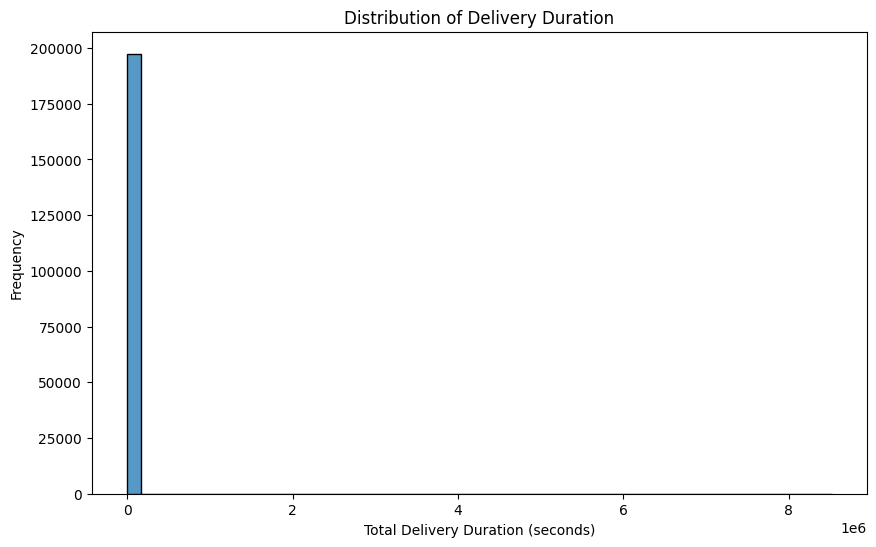

In [10]:
# Plot distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['total_delivery_duration'], bins=50)
plt.xlabel('Total Delivery Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Delivery Duration')
plt.show()

We don't see a clear distribution. The issue might be due to the presence of some very large values (outliers) or the distribution being highly skewed, which causes the histogram to show a single bar near zero.

Capping the extreme values at a certain percentile (e.g., the 99th percentile) to reduce the impact of outliers on the histogram.

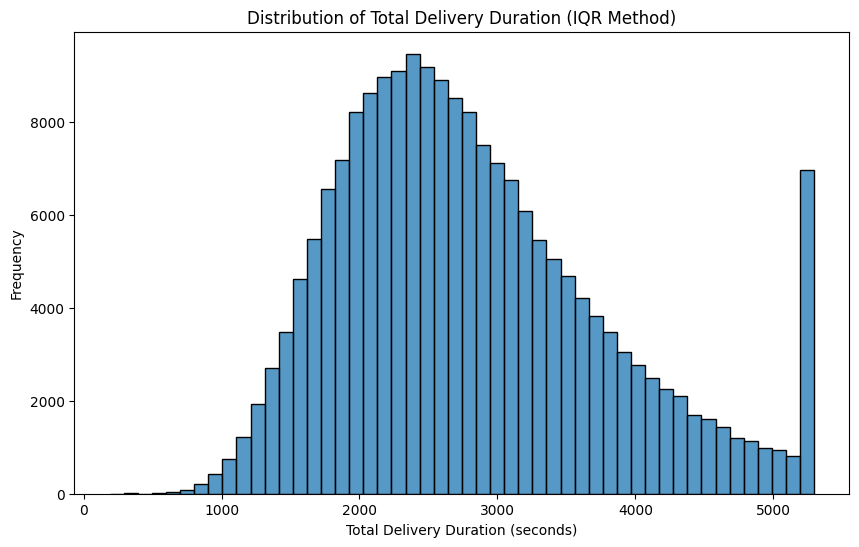

In [11]:
# Calculate the IQR for total_delivery_duration
Q1 = data['total_delivery_duration'].quantile(0.25)
Q3 = data['total_delivery_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mark outliers in a new column
data['total_delivery_duration_is_outlier'] = (data['total_delivery_duration'] < lower_bound) | (data['total_delivery_duration'] > upper_bound)

# Correct the outliers by clipping to the IQR bounds
data['total_delivery_duration_corrected'] = data['total_delivery_duration'].clip(lower=lower_bound, upper=upper_bound)

# Plot the histogram after handling outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['total_delivery_duration_corrected'], bins=50)
plt.xlabel('Total Delivery Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Delivery Duration (IQR Method)')
plt.show()

Comments:

1.	Right-Skewed Distribution: The distribution of delivery duration is right-skewed, indicating that while most deliveries occur within a shorter time frame (around 1,000 to 4,000 seconds), there are still a significant number of deliveries that take much longer. This skewness suggests the presence of some longer delivery times that could be influenced by various factors like traffic, order complexity, or restaurant preparation time.

2.	Mode Around 2,500 Seconds: The most common delivery duration (mode) is around 2,500 seconds, or approximately 41 minutes. This suggests that most deliveries tend to happen within a predictable range, which is helpful for building a predictive model.

3.	Long Tail (Outliers): Despite capping at the 99th percentile, there’s still a noticeable bump at the higher end (around 6,000 seconds). This may indicate some unusual circumstances affecting delivery time, such as severe traffic delays or special events. It could be worth investigating these outliers separately or engineering features that account for potential delay causes.

4.	Impact of Capping: Capping the data has helped in visualizing the overall distribution more clearly by limiting the influence of extreme outliers. This approach can improve model training by preventing those extreme values from overly impacting the learning process.

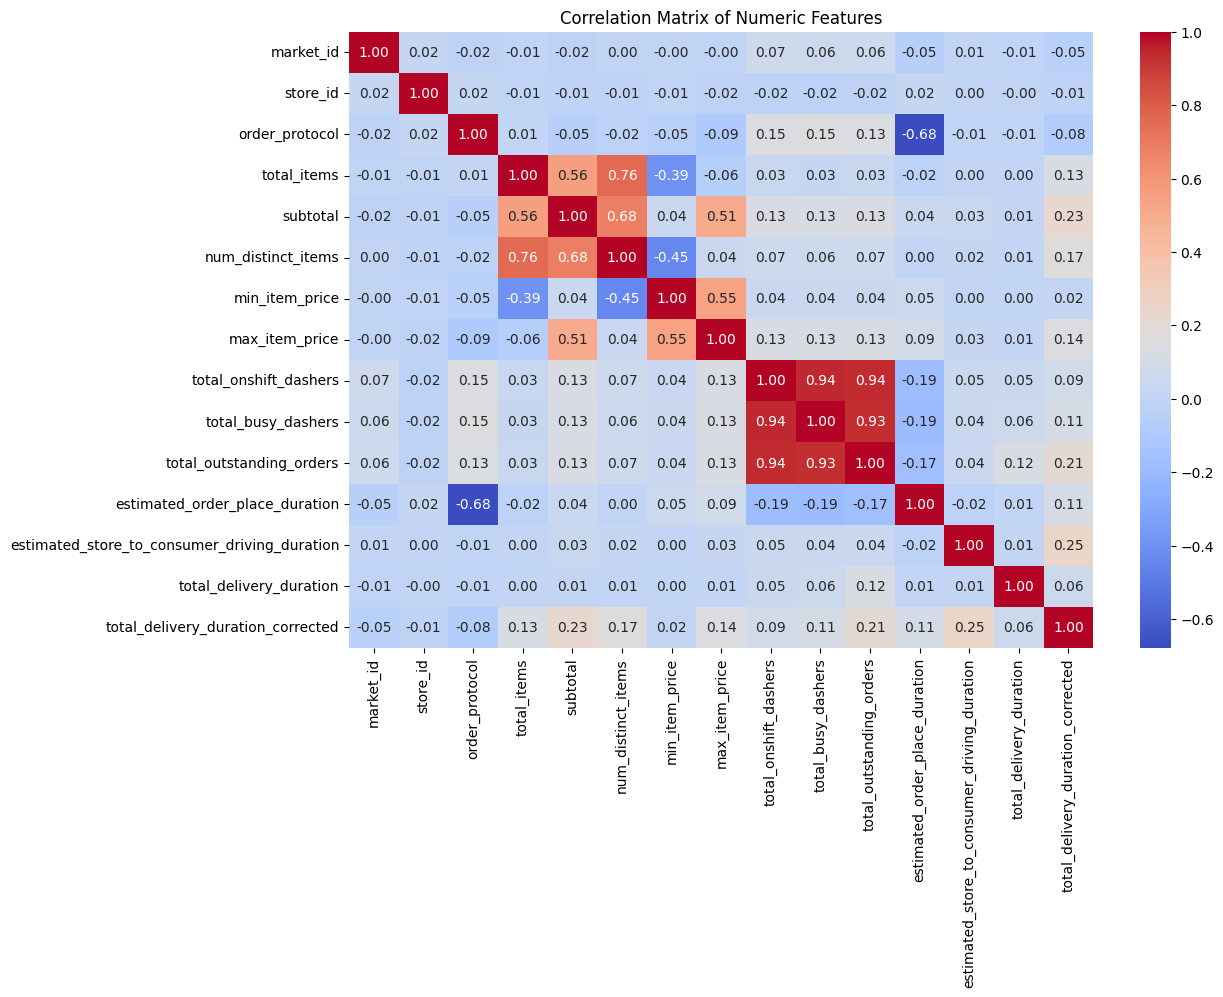

In [12]:
# Correlation matrix for numeric features
numeric_features = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_features.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

Comments:

1. High Correlation Among Dasher Features:

- The features total_onshift_dashers, total_busy_dashers, and total_outstanding_orders exhibit high correlations with each other (correlation values close to 0.94). This suggests that these features may provide redundant information, and their relationships should be considered during feature selection or engineering (e.g., combining them into a single feature or performing dimensionality reduction techniques like PCA).

2. Negative Correlation with estimated_order_place_duration:

- The feature estimated_order_place_duration has a moderate negative correlation with total_items (-0.68). This indicates that orders with a higher number of items may have a slightly lower estimated time to place the order, potentially due to the operational efficiency of certain restaurants. It could be worthwhile to explore this relationship further or create interaction features.

3. Moderate Correlation with subtotal and Related Features:

- The features subtotal, num_distinct_items, and total_items show moderate positive correlations among themselves, suggesting that larger orders tend to have a higher variety and total item count. These correlations may affect the model’s interpretation if all features are included, so some form of feature selection or regularization might be beneficial.

4. Weak Correlation with Target Variables:

- The correlation values for the original total_delivery_duration, the capped version, and the log-transformed version are generally low with most other features. This suggests that individual features alone may not have a strong linear relationship with delivery duration, indicating the need for more complex models (e.g., tree-based models or neural networks) to capture non-linear relationships.

5. Potential Feature Engineering Opportunities:

- The relatively low correlation with the target variable implies that combining features or deriving new ones (such as ratios, interactions, or time-based features) could improve predictive performance.

- For example, creating features based on ratios between total_busy_dashers and total_onshift_dashers could better capture the real-time workload on delivery capacity.

In [13]:
# Fill missing values for specific columns with median or other strategies
data['total_onshift_dashers'] = data['total_onshift_dashers'].fillna(data['total_onshift_dashers'].median())
data['total_busy_dashers'] = data['total_busy_dashers'].fillna(data['total_busy_dashers'].median())
data['total_outstanding_orders'] = data['total_outstanding_orders'].fillna(data['total_outstanding_orders'].median())
data['market_id'] = data['market_id'].fillna(-1)  # Using -1 to indicate unknown market_id
data['order_protocol'] = data['order_protocol'].fillna(-1)  # Using -1 for unknown order_protocol

Handling Outliers

In [14]:
# Define a function to mark outliers based on the IQR method
def handle_outliers(df, columns):
    """
    Handles outliers for the specified columns using the IQR method. 
    Outliers are values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to process
    
    Returns:
    - df: pandas DataFrame with outliers handled
    """
    for column in columns:
        # Skip columns with all missing values
        if df[column].isna().all():
            continue
        
        # Calculate Q1, Q3, and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Mark outliers in a new column
        df[column + '_is_outlier'] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return df

# List of numerical columns to handle outliers
numerical_columns = [
    'total_items', 'subtotal', 'num_distinct_items', 
    'min_item_price', 'max_item_price', 'total_onshift_dashers', 
    'total_busy_dashers', 'total_outstanding_orders', 
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration'
]

# Handle outliers in the dataset
data = handle_outliers(data, numerical_columns)

# Display the first few rows to verify the new columns
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_items_is_outlier,subtotal_is_outlier,num_distinct_items_is_outlier,min_item_price_is_outlier,max_item_price_is_outlier,total_onshift_dashers_is_outlier,total_busy_dashers_is_outlier,total_outstanding_orders_is_outlier,estimated_order_place_duration_is_outlier,estimated_store_to_consumer_driving_duration_is_outlier
0,1.0,2015-02-06 22:24:17+00:00,2015-02-06 23:27:16+00:00,1845,american,1.0,4,3441,4,557,...,False,False,False,False,False,False,False,False,False,False
1,2.0,2015-02-10 21:49:25+00:00,2015-02-10 22:56:29+00:00,5477,mexican,2.0,1,1900,1,1400,...,False,False,False,False,False,False,False,False,False,False
2,3.0,2015-01-22 20:39:28+00:00,2015-01-22 21:09:09+00:00,5477,NaN,1.0,1,1900,1,1900,...,False,False,False,False,False,False,False,False,False,False
3,3.0,2015-02-03 21:21:45+00:00,2015-02-03 22:13:00+00:00,5477,NaN,1.0,6,6900,5,600,...,False,True,False,False,False,False,False,False,False,False
4,3.0,2015-02-15 02:40:36+00:00,2015-02-15 03:20:26+00:00,5477,NaN,1.0,3,3900,3,1100,...,False,False,False,False,False,False,False,False,False,False


Create a relationship between total_busy_dashers and total_onshift_dashers

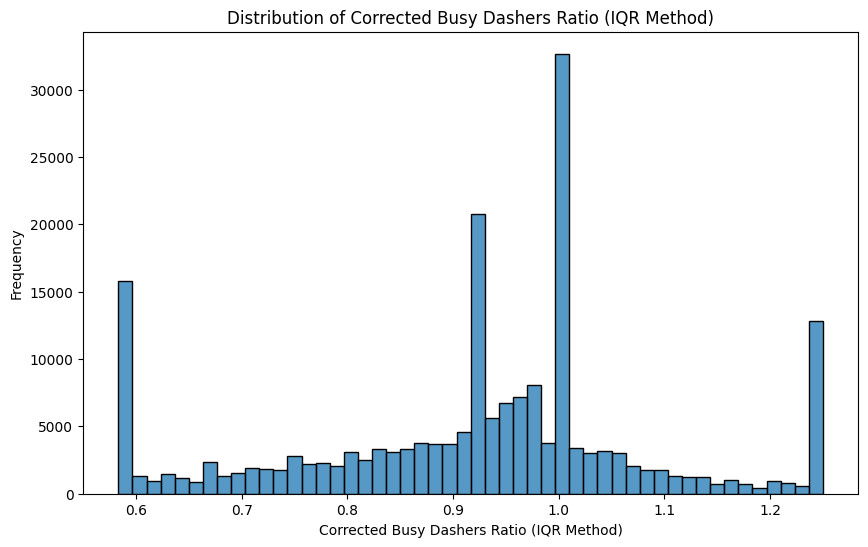

In [15]:
# Calculate the busy_dashers_ratio, ensuring the denominator is not zero
data['busy_dashers_ratio'] = data['total_busy_dashers'] / data['total_onshift_dashers'].replace(0, np.nan)

# Replace invalid values (negative or NaN) with zero
data['busy_dashers_ratio'] = data['busy_dashers_ratio'].clip(lower=0).fillna(0)

# Calculate the IQR bounds for detecting outliers
Q1 = data['busy_dashers_ratio'].quantile(0.25)
Q3 = data['busy_dashers_ratio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mark outliers in a new column
data['busy_dashers_ratio_is_outlier'] = (data['busy_dashers_ratio'] < lower_bound) | (data['busy_dashers_ratio'] > upper_bound)

# Correct the outliers by clipping them to the IQR bounds
data['busy_dashers_ratio_corrected'] = data.apply(
    lambda row: upper_bound if row['busy_dashers_ratio_is_outlier'] and row['busy_dashers_ratio'] > upper_bound 
    else (lower_bound if row['busy_dashers_ratio_is_outlier'] and row['busy_dashers_ratio'] < lower_bound 
          else row['busy_dashers_ratio']), axis=1)

# Plot the distribution after handling outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['busy_dashers_ratio_corrected'], bins=50)
plt.xlabel('Corrected Busy Dashers Ratio (IQR Method)')
plt.ylabel('Frequency')
plt.title('Distribution of Corrected Busy Dashers Ratio (IQR Method)')
plt.show()

Comments:

1.	Peaks Around 0.6, 0.9, and 1.0:
- The peaks around 0.6 and 0.9 suggest common scenarios where a specific proportion of dashers are busy. The value at 0.6 could indicate lower demand times when fewer dashers are actively working on deliveries.

- The prominent peak at 1.0 indicates a situation where the number of busy dashers matches the total number of dashers on shift, suggesting full utilization. This could represent periods of high demand when all available dashers are engaged.

2. Significant Variability Between 0.7 and 1.1:
- There is a wide spread between 0.7 and 1.1, indicating that the workload fluctuates significantly across different times. This variability can be important for predicting delivery duration, as higher values likely correlate with longer wait times due to increased demand.

3. Cluster at the Upper Limit (1.2):
- The presence of a cluster at the rightmost end (1.2) shows that some values were capped at the upper bound determined by the IQR. This indicates cases with extreme workload conditions, where a high proportion of dashers are busy. These cases might need special attention during modeling, as they can represent bottlenecks or high-stress periods.

4. Impact of Outlier Correction:
- The IQR method effectively reduced the range of extreme values while still capturing the essential variability in the data. The distinct peaks suggest that the feature retains important information about the distribution of dashers’ workload.

5. Modeling Implications:
- The corrected busy_dashers_ratio can be a significant predictor for modeling delivery times, especially since it highlights different levels of demand and operational stress.

- It may be beneficial to explore transformations or interaction features with other variables (e.g., total outstanding orders or time of day) to improve the feature’s effectiveness in the model.

Combine highly correlated features

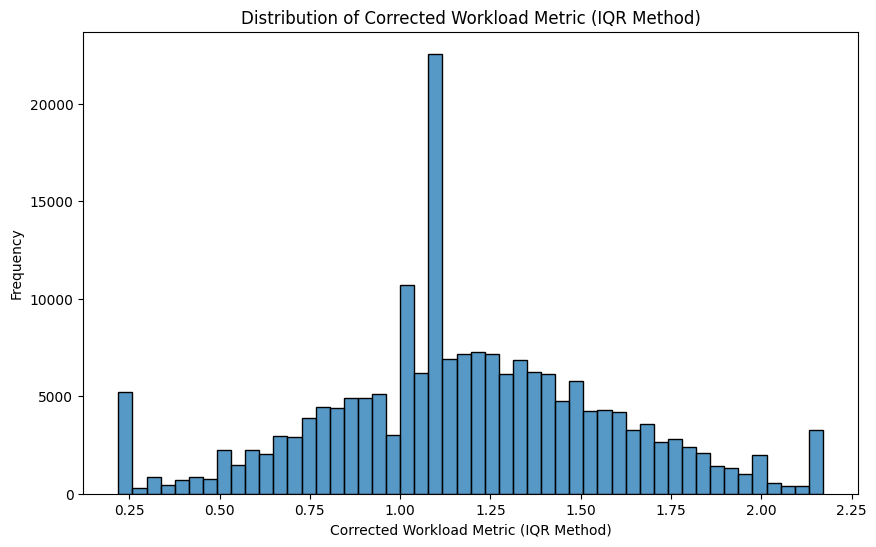

In [16]:
# Calculate the workload metric, ensuring the denominator is not zero
data['workload_metric'] = data['total_outstanding_orders'] / data['total_onshift_dashers'].replace(0, np.nan)

# Replace invalid values (negative or NaN) with zero
data['workload_metric'] = data['workload_metric'].clip(lower=0).fillna(0)

# Use the previously calculated outliers to correct the workload_metric
# Assuming the outlier column is named 'workload_metric_is_outlier'

# Get the IQR bounds calculated earlier
Q1 = data['workload_metric'].quantile(0.25)
Q3 = data['workload_metric'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mark outliers in a new column
data['workload_metric_is_outlier'] = (data['workload_metric'] < lower_bound) | (data['workload_metric'] > upper_bound)

# Replace outliers with the respective bounds
data['workload_metric_corrected'] = data.apply(
    lambda row: upper_bound if row['workload_metric_is_outlier'] and row['workload_metric'] > upper_bound 
    else (lower_bound if row['workload_metric_is_outlier'] and row['workload_metric'] < lower_bound 
          else row['workload_metric']), axis=1)

# Plot the distribution after handling outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['workload_metric_corrected'], bins=50)
plt.xlabel('Corrected Workload Metric (IQR Method)')
plt.ylabel('Frequency')
plt.title('Distribution of Corrected Workload Metric (IQR Method)')
plt.show()

Comments:

1. Prominent Peak Around 1.0:
- The peak at 1.0 suggests that many instances have a balanced workload where the number of outstanding orders is roughly equal to the number of onshift dashers. This indicates times when the workload is evenly distributed across the dashers.

2. Broad Distribution from 0.5 to 1.5:
- The spread between 0.5 and 1.5 shows significant variability in workload, with most values clustering within this range. This variation can reflect different demand scenarios and the availability of dashers.

- The wider spread suggests that there are times of both lower and higher than average workload, which could impact delivery times.

3. Clustering Around the Upper Limit (~2.2):
- The presence of a cluster near the upper bound indicates that some values were capped at the IQR threshold, representing instances with high workload. These cases may still have a significant impact on delivery time, as dashers are likely to be stretched thin during these periods.

- This cluster also indicates that while the IQR method mitigated extreme values, there are still cases where the workload was exceptionally high.
	
4. Low Values Near 0.25:
- The frequency of lower values (~0.25) suggests periods of relatively low demand or higher availability of dashers relative to the outstanding orders. This might represent times when the system has excess capacity.

5. Implications for Modeling:
- The variability in the corrected workload_metric provides valuable information for predicting delivery durations, as different levels of workload can affect the speed and efficiency of deliveries.

- The peak at 1.0 and the spread around it can be used to identify typical versus atypical workload conditions, which may help improve model accuracy.

- Additional transformations (e.g., logarithmic scaling) or interaction features could be considered to capture non-linear relationships in the data.


Create interactions between subtotal and num_distinct_items

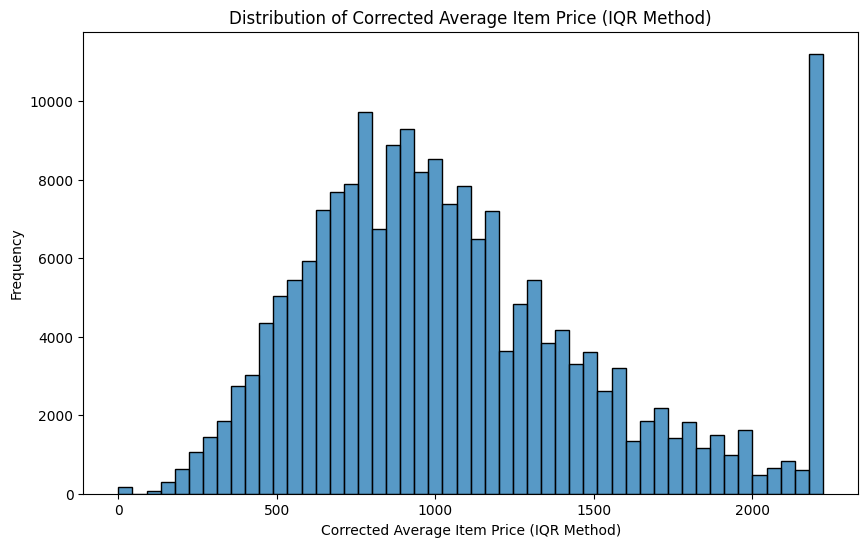

In [17]:
# Calculate the average item price
data['avg_item_price'] = data['subtotal'] / data['num_distinct_items']

# Fill any NaN values that might have resulted from division by zero
data['avg_item_price'] = data['avg_item_price'].fillna(0)

# Calculate outliers using the IQR method
Q1 = data['avg_item_price'].quantile(0.25)
Q3 = data['avg_item_price'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mark outliers in a new column
data['avg_item_price_is_outlier'] = (data['avg_item_price'] < lower_bound) | (data['avg_item_price'] > upper_bound)

# Correct the outliers by clipping to the IQR bounds
data['avg_item_price_corrected'] = data.apply(
    lambda row: upper_bound if row['avg_item_price_is_outlier'] and row['avg_item_price'] > upper_bound 
    else (lower_bound if row['avg_item_price_is_outlier'] and row['avg_item_price'] < lower_bound 
          else row['avg_item_price']), axis=1)

# Plot the distribution after handling outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['avg_item_price_corrected'], bins=50)
plt.xlabel('Corrected Average Item Price (IQR Method)')
plt.ylabel('Frequency')
plt.title('Distribution of Corrected Average Item Price (IQR Method)')
plt.show()

Comments:

1. Right-Skewed Distribution:
- The distribution is right-skewed, with a long tail extending toward higher values. This suggests that while most orders have an average item price below 1,500 cents (or $15 if we consider cents to dollars), there are still a significant number of orders with higher average prices.

- The right skew is common in price-related data, as some high-end items or larger orders can increase the average item price.

2. Peak Near the Upper Bound:
- The noticeable spike at the upper end (around 2,000 cents) indicates that many values have been capped at the IQR upper bound. This is a result of outlier correction and suggests that some orders had an average item price well above the typical range before correction.

- While capping the outliers helps manage extreme values, the spike may also suggest that further refinement could be considered, such as using a different transformation (e.g., logarithmic) to compress the range.

3. High Frequency Around 500 to 1,000 Cents:
- The concentration of values between 500 and 1,000 cents (or $5 to $10) indicates that most items fall within this price range. This range likely corresponds to standard menu items in restaurants (e.g., sides, small meals).
- This pattern suggests that the dataset contains a mix of low and medium-priced items, which could be useful for understanding the price sensitivity and typical order composition.

4. Modeling Implications:
- The avg_item_price feature, after correction, can provide valuable information for predicting delivery duration, as higher average item prices might be associated with more complex or time-consuming orders.
- Given the skewness and the capped peak, it may be beneficial to apply further transformations (e.g., logarithmic scaling) or create interaction features with other variables (such as total_items or subtotal) to enhance its predictive power.

5. Handling of Corrected Values:
- The capping of outliers ensures that extreme values do not disproportionately influence the model. However, the presence of the peak at the upper limit indicates that these cases represent atypical situations that could still have a significant impact on delivery time predictions.

Explore interactions with the day and hour

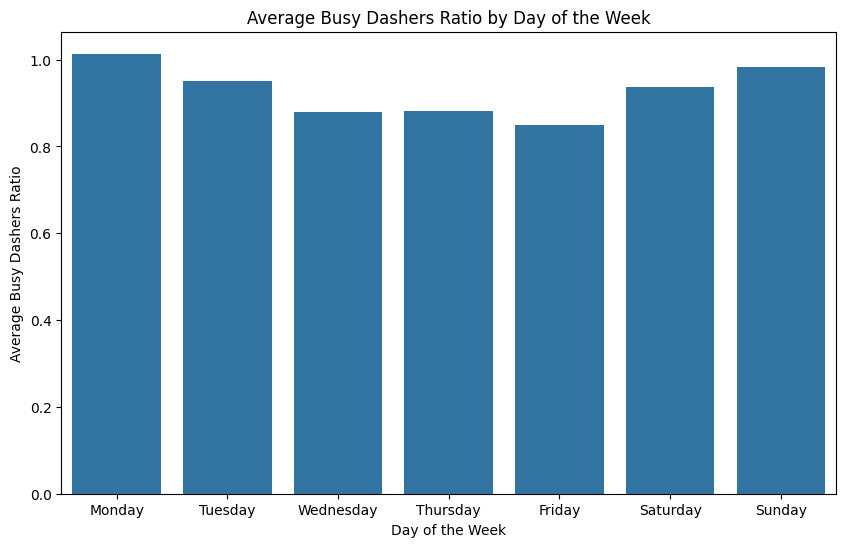

In [18]:
# Ensure that 'day_of_week' is present; if not, create it from 'created_at'
if 'day_of_week' not in data.columns:
    # Convert 'created_at' to datetime if it is not already
    data['created_at'] = pd.to_datetime(data['created_at'], utc=True)
    # Extract the day of the week (0 = Monday, 6 = Sunday)
    data['day_of_week'] = data['created_at'].dt.dayofweek

# Group data by day of the week and calculate the mean busy dashers ratio
day_busy_ratio = data.groupby('day_of_week')['busy_dashers_ratio'].mean()

# Plot the average busy dashers ratio by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=day_busy_ratio.index, y=day_busy_ratio.values)
plt.xlabel('Day of the Week')
plt.ylabel('Average Busy Dashers Ratio')
plt.title('Average Busy Dashers Ratio by Day of the Week')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

1. Higher Ratios on Mondays and Sundays:
- The average busy_dashers_ratio is highest on Mondays and Sundays, indicating that dashers are generally busier on these days. This could be due to higher order volumes or fewer dashers being available, leading to a higher workload for each dasher.

- These peaks suggest that Mondays and Sundays may be peak demand days, possibly driven by weekend closures of some restaurants or an increase in home deliveries.

2. Mid-Week Lower Activity (Wednesday to Friday):
- The ratio tends to be lower from Wednesday to Friday, indicating that the workload per dasher is relatively lower on these days. This could imply that there is either a higher availability of dashers or a lower demand for deliveries mid-week.
- This trend suggests a more balanced workload during these days, possibly due to a steadier flow of orders and better alignment between supply (available dashers) and demand.

3. Slight Increase on Saturday:
- There is a noticeable uptick in the average busy_dashers_ratio on Saturday, which suggests that weekends still see higher activity compared to mid-week days.
- The increase on Saturday may be due to more leisure activities and dining out, which could affect delivery patterns.

4. Implications for Modeling:
- The variation in busy_dashers_ratio across the week can be an important feature for predicting delivery times, as higher ratios likely correlate with longer delivery durations due to higher workload.
- You could consider creating additional features that capture this weekly pattern, such as binary indicators for peak days (e.g., Monday and Sunday) or using the day_of_week as a categorical feature in the model.

5. Potential Operational Insights:
- For operational planning, this chart suggests that staffing levels might need adjustment on Mondays and Sundays to meet higher demand.

- Incentives for dashers to work during these peak times could help balance the workload and improve delivery efficiency.

In [21]:
# Save the dataset after EDA and any necessary transformations
data.to_csv("../data/processed/data_eda.csv", index=False)
